# 用Adversarial density-ratio estimation估计KL的学习
Given a convex function $f$ for which $f(1) = 0$, the $f-$divergence between $p_x$ and $p_y$ is defined as
$$D_f(p_x||p_y) = \int f({\frac{p_x(x)}{p_y(x)}}) p_x(x)dx$$
For example, the choice $f(t) = tlog t$ corresponds to $D_f (p_{x}p_y) = D_{KL}(p_{x}p_y)$. Given samples
from $p_x$ and $p_y$ we can estimate the $f-$divergence using the density-ratio trick , popularized
recently through the generative adversarial network (GAN) framework. The trick is to express
$p_x$ and $p_y$ as conditional distributions, conditioned on a label $c \in \{0, 1\}$, and reduce the task to
binary classification. In particular, let $p_x(x) = p(x|c = 1)$, $p_y(x) = p(x|c = 0)$, and consider a
discriminator $Sη$ trained to predict the probability that its input is a sample from distributions px
rather than py, i.e, predict $p(c = 1|x)$. The density ratio can be expressed as
$$\frac{p_x(x)}{p_y(x)} = \frac{p(x|c = 1)}{p(x|c = 0)} = \frac{p(c = 1|x)}{p(c = 0|x)} = \frac{Sη(x)}{1-Sη(x)}$$
where the second equality follows from Bayes’ rule under the assumption that the marginal class
probabilities are equal. As such, given N i.i.d. samples $\{x^{(i)}\}^N_{i=1}$ from $p_x$ and a trained classifier$Sη$ one can estimate the KL-divergence by simply computing
$$D_{KL}(p_x(x)||p_y(x)) = \frac{1}{N}\sum_{i=0}^{N}log\frac{Sη(x^{(i)})}{1-Sη(x^{(i)})}$$
As a practical alternative, some approaches replace the KL term in (1) with an arbitrary divergence
(e.g., maximum mean discrepancy). Note, however, that the resulting objective does not necessarily
lower-bound the marginal log-likelihood of the data.
![image](Images/2019_3_13_1.png)

现在，我们假设要估计的两个分布是高斯分布，均值方差如下：

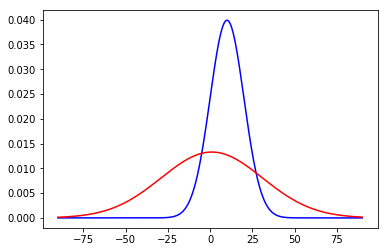

In [140]:
import numpy as np
import matplotlib.pyplot as plt
mu1 = 10
sigma1 = 10
mu2 = 1
sigma2 = 30
x = np.linspace(-90,90,1000)
y1 = 1/(np.sqrt(2*np.pi)*sigma1)*np.exp(-0.5*(x-mu1)**2/sigma1**2)
y2 = 1/(np.sqrt(2*np.pi)*sigma2)*np.exp(-0.5*(x-mu2)**2/sigma2**2)
plt.plot(x,y1,'b')
plt.plot(x,y2,'r')
plt.show()

## 理论计算两个高斯分布的KL散度
如果两个分布都是高斯分布，kl散度可以使用下面的公式计算:
$$ D_{KL}(p_1||p_2) = log\frac{\sigma_2}{\sigma_1} + \frac{\sigma_1^2 + (\mu_1 - \mu_2)^2}{2\sigma_2^2}-\frac{1}{2}$$

In [141]:
KL = np.log(sigma2/sigma1) + (sigma1**2+(mu1-mu2)**2)/(2*sigma2**2) - 0.5
print(KL)

0.6991678442236653


In [142]:
#接下来对两个分布进行采样
import torch
e1 = np.random.normal(size=1000)
s1 = mu1 + e1*sigma1
e2 = np.random.normal(size=1000)
s2 = mu2 + e2*sigma2

我们建立一个两层的神经网络来模拟一个判别器

In [143]:
import torch.nn as nn
import torch.nn.init as init
def kaiming_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        init.kaiming_normal(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d)):
        m.weight.data.fill_(1)
        if m.bias is not None:
            m.bias.data.fill_(0)
class Discriminator(nn.Module):
    """Model proposed in understanding beta-VAE paper(Burgess et al, arxiv:1804.03599, 2018)."""

    def __init__(self):
        super(Discriminator, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 100),               # B, 256
            nn.ReLU(True),
            nn.Linear(100, 1),                 # B, 256
            nn.Sigmoid(),
        )
        self.weight_init()

    def weight_init(self):
        for block in self._modules:
            for m in self._modules[block]:
                kaiming_init(m)
    def forward(self, x):
        v = self.layers(x)
        return v

In [144]:
x = np.concatenate((s1,s2))
y = np.concatenate((np.array([1]*1000),np.array([0]*1000)))
rng_state = np.random.get_state()
np.random.shuffle(x)
np.random.set_state(rng_state)
np.random.shuffle(y)
x = torch.FloatTensor(x).unsqueeze(1)
y = torch.FloatTensor(y).unsqueeze(1)
def return_data(it):
    return x[100*(it-1):it*100,:],y[100*(it-1):it*100]

In [148]:
from tqdm import tqdm
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
net = Discriminator()
criterion = nn.BCELoss()
def train():
    optimizer = optim.Adam(net.parameters(), lr=10e-4,
                                    betas=(0.9, 0.99))
    print("training start!!!")
    global_iter = 0
    it = 1
    pbar = tqdm(total=1000)
    pbar.update(global_iter)
    for i in range(1000):
        x_,y_ = return_data(it)
        pbar.update(1)
        if it == 10:
            it = 1
        else:
            it += 1
        global_iter += 1
        x_ = Variable(x_)
        y_ = Variable(y_)
        value = net(x_)
        adv_loss = criterion(value,y_)
        print(adv_loss)
        optimizer.zero_grad()
        adv_loss.backward()
        optimizer.step()
    pbar.close()

C:\Users\v-tayan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  """


In [149]:
train()

training start!!!













  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

tensor(7.4977, grad_fn=<BinaryCrossEntropyBackward>)
tensor(8.0796, grad_fn=<BinaryCrossEntropyBackward>)
tensor(9.1778, grad_fn=<BinaryCrossEntropyBackward>)
tensor(8.0642, grad_fn=<BinaryCrossEntropyBackward>)
tensor(7.7316, grad_fn=<BinaryCrossEntropyBackward>)
tensor(7.2201, grad_fn=<BinaryCrossEntropyBackward>)
tensor(9.2829, grad_fn=<BinaryCrossEntropyBackward>)
tensor(5.0664, grad_fn=<BinaryCrossEntropyBackward>)
tensor(6.5580, grad_fn=<BinaryCrossEntropyBackward>)
tensor(4.7828, grad_fn=<BinaryCrossEntropyBackward>)
tensor(3.6249, grad_fn=<BinaryCrossEntropyBackward>)
tensor(3.1950, grad_fn=<BinaryCrossEntropyBackward>)
tensor(2.4252, grad_fn=<BinaryCrossEntropyBackward>)
tensor(2.6226, grad_fn=<BinaryCrossEntropyBackward>)
tensor(1.6976, grad_fn=<BinaryCrossEntropyBackward>)
tensor(1.4949, grad_fn=<BinaryCrossEntropyBackward>)
tensor(1.2865, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7004, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6565, grad_fn=<BinaryCrossEntropyBack












  4%|███▍                                                                           | 44/1000 [00:00<00:02, 432.35it/s]

tensor(0.8689, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7047, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7538, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6325, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7443, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6770, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.8193, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6994, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6994, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5785, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7206, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5950, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6566, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6058, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7122, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6333, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7416, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.7198, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6793, grad_fn=<BinaryCrossEntropyBack












  8%|██████▌                                                                        | 83/1000 [00:00<00:02, 417.67it/s]

tensor(0.5424, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6172, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5700, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5899, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5803, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6153, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5766, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6019, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6147, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6072, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5342, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6129, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5626, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5913, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5894, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6115, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5706, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6103, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6265, grad_fn=<BinaryCrossEntropyBack












 12%|█████████                                                                     | 116/1000 [00:00<00:02, 383.77it/s]

tensor(0.5860, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5951, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6032, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5678, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6032, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6198, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6049, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5257, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5985, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5487, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5827, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5911, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5995, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5660, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6015, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6180, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6009, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5210, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5947, grad_fn=<BinaryCrossEntropyBack












 16%|████████████▍                                                                 | 159/1000 [00:00<00:02, 396.27it/s]

tensor(0.5613, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6034, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6198, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5944, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5107, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5836, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5378, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5764, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5873, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5877, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5602, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6028, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6187, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5919, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5077, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5800, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5348, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5738, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5856, grad_fn=<BinaryCrossEntropyBack












 20%|███████████████▋                                                              | 201/1000 [00:00<00:02, 397.63it/s]

tensor(0.6132, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5833, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4987, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5701, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5267, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5656, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5789, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5775, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5566, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5998, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6113, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5805, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4959, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5671, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5243, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5629, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5767, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5752, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5560, grad_fn=<BinaryCrossEntropyBack












 24%|███████████████████                                                           | 245/1000 [00:00<00:01, 407.45it/s]

tensor(0.5178, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5555, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5703, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5694, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5547, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5973, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6039, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5705, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4860, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5563, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5159, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5532, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5683, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5676, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5544, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5968, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6022, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5682, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4838, grad_fn=<BinaryCrossEntropyBack












 28%|██████████████████████                                                        | 283/1000 [00:00<00:01, 397.22it/s]

tensor(0.4797, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5497, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5111, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5472, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5626, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5631, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5539, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5961, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5978, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5622, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4779, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5477, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5097, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5455, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5609, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5618, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5538, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5960, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5966, grad_fn=<BinaryCrossEntropyBack












 32%|█████████████████████████▎                                                    | 324/1000 [00:00<00:01, 400.65it/s]

tensor(0.5425, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5063, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5410, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5563, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5585, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5540, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5963, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5936, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5558, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4714, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5409, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5053, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5397, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5550, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5576, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5542, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5966, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5929, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5544, grad_fn=<BinaryCrossEntropyBack












 36%|████████████████████████████▍                                                 | 364/1000 [00:00<00:01, 399.54it/s]

tensor(0.5369, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5030, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5364, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5513, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5552, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5549, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5976, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5910, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5509, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4664, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5357, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5024, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5354, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5502, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5545, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5551, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5981, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5905, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5498, grad_fn=<BinaryCrossEntropyBack












 40%|███████████████████████████████▍                                              | 403/1000 [00:01<00:01, 395.10it/s]

tensor(0.4634, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5326, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5010, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5330, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5474, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5529, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5561, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5996, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5894, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5471, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4626, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5317, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5006, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5324, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5465, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5525, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5564, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6002, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5892, grad_fn=<BinaryCrossEntropyBack












 44%|██████████████████████████████████▍                                           | 442/1000 [00:01<00:01, 390.87it/s]

tensor(0.5449, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4603, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5294, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4998, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5306, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5443, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5514, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5575, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6019, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5886, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5442, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4596, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5287, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4995, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5302, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5437, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5512, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5579, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6025, grad_fn=<BinaryCrossEntropyBack












 49%|█████████████████████████████████████▉                                        | 486/1000 [00:01<00:01, 404.12it/s]

tensor(0.5290, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5420, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5505, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5590, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6044, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5883, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5420, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4574, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5265, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4990, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5286, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5415, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5503, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5593, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6050, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5883, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5415, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4570, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5260, grad_fn=<BinaryCrossEntropyBack












 53%|█████████████████████████████████████████                                     | 526/1000 [00:01<00:01, 397.73it/s]

tensor(0.5277, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5402, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5499, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5604, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6067, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5883, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5403, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4558, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5249, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4988, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5275, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5398, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5498, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5607, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6073, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5883, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5400, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4554, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5246, grad_fn=<BinaryCrossEntropyBack












 57%|████████████████████████████████████████████▏                                 | 567/1000 [00:01<00:01, 399.26it/s]

tensor(0.5388, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5496, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5616, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6088, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5884, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5390, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4545, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5237, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4987, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5267, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5385, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5495, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5619, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6093, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5884, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5387, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4542, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5235, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4987, grad_fn=<BinaryCrossEntropyBack












 61%|███████████████████████████████████████████████▎                              | 607/1000 [00:01<00:00, 396.19it/s]

tensor(0.5377, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5494, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5627, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6106, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5885, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5380, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4535, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5229, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4987, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5261, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5374, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5494, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5630, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6110, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5886, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5378, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4533, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5227, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4987, grad_fn=<BinaryCrossEntropyBack












 65%|██████████████████████████████████████████████████▌                           | 648/1000 [00:01<00:00, 399.34it/s]

tensor(0.5493, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5636, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6121, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5886, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5372, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4527, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5223, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4987, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5256, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5366, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5493, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5638, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6124, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5886, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5370, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4526, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5222, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4987, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5255, grad_fn=<BinaryCrossEntropyBack












 69%|█████████████████████████████████████████████████████▋                        | 689/1000 [00:01<00:00, 401.57it/s]

tensor(0.5644, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6133, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5886, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5365, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4522, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5218, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4987, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5252, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5359, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5492, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5645, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6136, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5886, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5364, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4520, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5218, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4987, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5252, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5357, grad_fn=<BinaryCrossEntropyBack












 73%|█████████████████████████████████████████████████████████                     | 731/1000 [00:01<00:00, 404.84it/s]

tensor(0.5886, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5360, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4517, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5215, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4986, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5249, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5353, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5492, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5651, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6145, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5886, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5359, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4516, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5214, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4986, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5249, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5351, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5491, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5652, grad_fn=<BinaryCrossEntropyBack












 77%|████████████████████████████████████████████████████████████▎                 | 773/1000 [00:01<00:00, 409.26it/s]

tensor(0.4514, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5212, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4986, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5247, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5347, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5491, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5655, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6153, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5885, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5355, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4513, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5211, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4986, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5246, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5346, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5491, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5656, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6154, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5885, grad_fn=<BinaryCrossEntropyBack












 82%|███████████████████████████████████████████████████████████████▋              | 816/1000 [00:02<00:00, 413.75it/s]

tensor(0.5245, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5342, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5490, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5658, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6158, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5884, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5352, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4510, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5209, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4986, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5244, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5341, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5490, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5658, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6159, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5883, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5351, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4509, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5208, grad_fn=<BinaryCrossEntropyBack












 86%|███████████████████████████████████████████████████████████████████▏          | 862/1000 [00:02<00:00, 425.11it/s]

tensor(0.5348, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4507, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5207, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4985, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5243, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5336, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5489, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5660, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6162, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5881, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5348, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4507, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5207, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4985, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5243, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5335, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5489, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5660, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6163, grad_fn=<BinaryCrossEntropyBack












 91%|██████████████████████████████████████████████████████████████████████▊       | 908/1000 [00:02<00:00, 432.22it/s]

tensor(0.5488, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5660, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6164, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5879, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5344, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4504, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5205, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4985, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5241, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5330, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5487, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5660, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6164, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5878, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5344, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4504, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5205, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4985, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5241, grad_fn=<BinaryCrossEntropyBack












 95%|██████████████████████████████████████████████████████████████████████████▎   | 952/1000 [00:02<00:00, 429.72it/s]

tensor(0.5342, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4503, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5204, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4985, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5240, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5326, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5486, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5660, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6166, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5875, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5341, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4502, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5204, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.4985, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5240, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5325, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5486, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5660, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6166, grad_fn=<BinaryCrossEntropyBack












100%|█████████████████████████████████████████████████████████████████████████████▋| 996/1000 [00:02<00:00, 431.78it/s]

tensor(0.5239, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5322, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5485, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.5660, grad_fn=<BinaryCrossEntropyBackward>)
tensor(0.6167, grad_fn=<BinaryCrossEntropyBackward>)













100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 407.79it/s]

In [150]:
index = net(x)
(index/(1-index)).log().sum()/1000

tensor(-1.7940, grad_fn=<DivBackward0>)